In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

In [3]:
!pip install keras-unet

In [4]:
import keras
from keras_unet.models import custom_unet

2023-04-07 15:18:08.377052: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/kunal.jain001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [5]:
DATAPATH = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/npy_files'
images_file = os.path.join(DATAPATH, 'fly-mar-06-original-images.npy')

In [6]:
images = np.load(images_file)

In [7]:
images.shape

(56, 512, 512)

In [8]:
SRCPATH = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/good_images/'

In [9]:
img_file_names = os.listdir(SRCPATH)

In [10]:
import mahotas as mh

In [11]:
test_slices = []


for img in img_file_names:
    if (img.endswith("tif")):
        a = mh.imread(os.path.join(SRCPATH, img))
        a = a.astype(np.float)
        a /= a.max()
        a *= 255
        a_cropped = a[1500:2012, 2968:3480].astype(np.float)

        test_slices.append(a_cropped)

/tmp/ipykernel_3601420/3445029487.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = a.astype(np.float)
/tmp/ipykernel_3601420/3445029487.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a_cropped = a[1500:2012, 2968:3480].astype(np.float)


In [12]:
test_slices = np.array(test_slices).astype(np.float64)

In [13]:
test_slices.shape

(253, 512, 512)

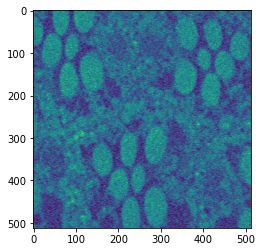

In [14]:
imshow(test_slices[100])

In [15]:
test_slices_expand_dims = np.expand_dims(test_slices, axis=3)

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import keras.optimizers
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

In [20]:
MODELPATH = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-07/'
MODELNAME = '04-06-32-500-89-0.05-0.02-0.99.hdf5'

In [21]:
loaded_model = keras.models.load_model(
    os.path.join(MODELPATH, MODELNAME),
    custom_objects={
        "iou": iou,
        "iou_thresholded": iou_thresholded,
        "accuracy": 'accuracy'
    })

2023-04-07 15:19:28.616949: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-07 15:19:28.874333: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-07 15:19:28.879405: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-07 15:19:28.879425: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-07 15:19:28.898627: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-07 

In [22]:
random_indices = np.random.choice(253, 10)

In [23]:
random_indices

array([ 16, 106,  53,  82, 196,  87, 137, 155,  30, 123])

In [24]:
ten_random_slices = np.empty([10, 512, 512, 1])
z = 0

for i in random_indices:
    ten_random_slices[z] = test_slices_expand_dims[i]
    z = z + 1

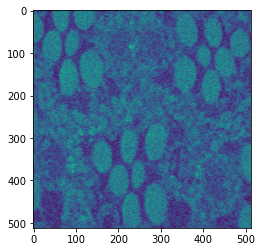

In [25]:
imshow(ten_random_slices[0])

In [26]:
ten_random_slices.shape

(10, 512, 512, 1)

In [53]:
test_slices_expand_dims.shape

(253, 512, 512, 1)

In [54]:
import time

start = time.time()

y_predict = loaded_model.predict(test_slices_expand_dims)

end = time.time()

print(end-start)

10.386674642562866


In [55]:
y_predict.shape

(253, 512, 512, 1)

In [56]:
y_predict = np.array(y_predict).astype(np.float64)

In [57]:
y_predict.shape

(253, 512, 512, 1)

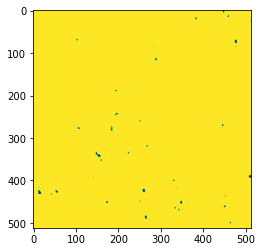

In [64]:
imshow(y_predict[179])

In [32]:
y_predict[3].shape

(512, 512, 1)

In [33]:
y_predict[3][:,:,0].shape

(512, 512)

In [34]:
a = y_predict[3,:,:,0] * 255

In [35]:
from PIL import Image

In [36]:
image = Image.fromarray((y_predict[3,:,:,0] * 255).astype(np.uint8))

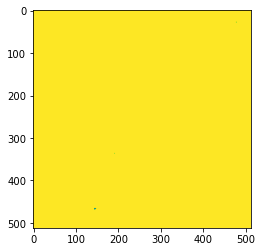

In [37]:
imshow(image)

In [38]:
min_value, max_value = image.getextrema()

In [39]:
new_max_value = 255
new_min_value = 0

In [40]:
scale = (new_max_value - new_min_value) / (max_value - min_value)

In [41]:
image = image.point(lambda i: (i - min_value) * scale + new_min_value)

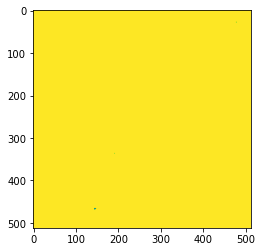

In [42]:
imshow(image)

In [43]:
y_predict[3] = np.expand_dims(np.array(image), axis=-1) / 255

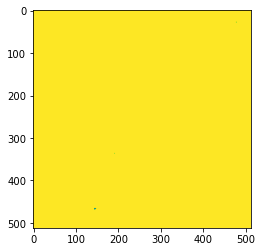

In [44]:
imshow(y_predict[3])